# Observing the Tie Dye Property

Generate representations on math dataset: 

```bash
python3 compute_minute_math_reps.py --output_dir results/tst2
python3 compute_minute_math_reps.py --output_dir results/tst3 --num_unique_problems 500
```

Now `results/tst` has the following files: 
```
answers.npy
args.json
internal_reps.pt
logits.pt
problems.npy
```

Let's start by loading these in. `answers` is just a list of list of ints, so it 
`problems`. `internal_reps.pt` is a list of tuples of tuples of tensors. `logits` 
is a list of tensors. 

In [16]:
import numpy as np
import torch
import json
import os
import matplotlib.pyplot as plt

In [17]:
# Define the directory containing the results
output_dir = '../results/tst3'

## Purity Functions

In [18]:
import torch
import torch.nn.functional as F

def calculate_purity(tensors, class_ids):
    """
    tensors: [batch, num_tokens, d_model] -- a given layer's internal reps
    class_ids: tensor of shape [batch] -- the answers for each problem
    """
    # Flatten the tensors along the num_tokens dimension
    tensors = tensors.view(tensors.size(0), -1)  # Shape: (Batch, num_tokens * d_model)

    # Normalize the vectors (ensuring we're working with unit vectors)
    tensors = F.normalize(tensors, p=2, dim=1)

    # Compute the cosine similarity matrix
    similarity_matrix = torch.mm(tensors, tensors.t())  # Shape: (Batch, Batch)

    # Transform similarity matrix from [-1, 1] to [0, 2]
    similarity_matrix = similarity_matrix + 1

    # Mask to exclude self-comparisons
    eye_mask = torch.eye(similarity_matrix.size(0), dtype=torch.bool, device=similarity_matrix.device)

    # Initialize masks for intra-class and inter-class similarities
    intra_class_mask = torch.zeros_like(similarity_matrix, dtype=torch.bool)
    inter_class_mask = torch.zeros_like(similarity_matrix, dtype=torch.bool)

    for i in range(len(class_ids)):
        for j in range(len(class_ids)):
            if class_ids[i] == class_ids[j]:
                intra_class_mask[i, j] = True
            else:
                inter_class_mask[i, j] = True

    # Exclude diagonal (self-similarities)
    intra_class_mask[eye_mask] = False

    # Calculate average similarities
    if intra_class_mask.any():
        intra_class_similarity = similarity_matrix[intra_class_mask].mean()
    else:
        intra_class_similarity = torch.tensor(0.0)

    if inter_class_mask.any():
        inter_class_similarity = similarity_matrix[inter_class_mask].mean()
    else:
        inter_class_similarity = torch.tensor(0.0)

    # Handle cases where inter-class similarity is zero to avoid division by zero
    if inter_class_similarity == 0:
        purity_score = torch.tensor(float('inf'))  # Consider infinite purity if there is no inter-class similarity
    else:
        purity_score = intra_class_similarity / inter_class_similarity

    return purity_score.item()

## Load Data

In [19]:
# Load the answers and problems files
answers = np.load(os.path.join(output_dir, 'answers.npy'))
problems = np.load(os.path.join(output_dir, 'problems.npy'))

# Load the internal representations and logits
internal_reps = torch.load(os.path.join(output_dir, 'internal_reps.pt'))
logits = torch.load(os.path.join(output_dir, 'logits.pt'))

# Load the arguments
with open(os.path.join(output_dir, 'args.json'), 'r') as f:
    args = json.load(f)

# Display the shapes and types of the loaded data
print("Answers shape:", answers.shape)
print("Problems shape:", problems.shape)
print("Internal Reps type:", type(internal_reps))
print("Internal Reps length:", len(internal_reps))
print("Logits type:", type(logits))
print("Logits length:", len(logits))

# Let's inspect the internal representations and logits a bit more closely
print("Example internal representation shape:", internal_reps[0][0][0].shape)
print("Example logits shape:", logits[0].shape)

# Display some examples from the loaded data
print("\nExample answers:", answers[0])
print("\nExample problems:", problems[0])
print("\nExample internal representation:", internal_reps[0][0][0])
print("\nExample logits:", logits[0])

Answers shape: (490, 1)
Problems shape: (490, 7)
Internal Reps type: <class 'list'>
Internal Reps length: 490
Logits type: <class 'torch.Tensor'>
Logits length: 490
Example internal representation shape: torch.Size([7, 4096])
Example logits shape: torch.Size([7, 128256])

Example answers: [868]

Example problems: [128000     20    489    220    605    284    220]

Example internal representation: tensor([[-8.2970e-05,  2.5749e-04, -2.4605e-04,  ..., -3.2425e-04,
         -2.1553e-04,  4.7112e-04],
        [ 1.8845e-03,  5.4626e-03,  1.3275e-03,  ...,  9.7046e-03,
         -1.7319e-03, -5.9204e-03],
        [ 1.1749e-03, -8.8501e-03,  1.6708e-03,  ..., -1.1673e-03,
         -2.6398e-03,  1.2329e-02],
        ...,
        [ 7.0572e-04,  4.0283e-03, -2.7657e-04,  ...,  2.2095e-02,
          2.0599e-03,  3.7079e-03],
        [ 1.0376e-03, -6.8054e-03,  6.2943e-04,  ...,  2.5482e-03,
         -8.3618e-03, -8.8501e-03],
        [-6.3324e-04,  1.0395e-04,  1.6327e-03,  ..., -1.9684e-03,
     

## Munge Data

`internal_reps` has shape 

In [20]:
class_ids = torch.tensor(answers[:, 0])
class_ids.shape

torch.Size([490])

In [21]:
def get_layer_activations(internal_reps, layer_idx):
    """
    Get the activations of a specific layer for all problems and all examples.

    internal_reps: list[tuple[tensor]] where internal_reps[question_num][layer_num]
     is a tensor of shape [batch=1, num_tokens, d_model=4096]

    We will return a tensor of shape [num_questions, num_tokens, d_model=4096]
    for the given layer
    """
    return torch.cat([internal_reps[i][layer_idx] for i in range(len(internal_reps))])


In [22]:
# iterate through each layer
num_layers = 33
purity_by_layer = []
for layer_num in range(num_layers):
    layer_activations = get_layer_activations(internal_reps, layer_num)
    purity = calculate_purity(layer_activations, torch.tensor(answers))
    print(f"Layer {layer_num} purity: {purity}")
    purity_by_layer.append(purity)

Layer 0 purity: 1.0011779069900513
Layer 1 purity: 1.0000756978988647
Layer 2 purity: 1.0000001192092896
Layer 3 purity: 1.000000238418579
Layer 4 purity: 1.0000004768371582
Layer 5 purity: 1.0000005960464478
Layer 6 purity: 1.0000008344650269
Layer 7 purity: 1.0000011920928955
Layer 8 purity: 1.0000011920928955
Layer 9 purity: 1.0000011920928955
Layer 10 purity: 1.000001311302185
Layer 11 purity: 1.000001311302185
Layer 12 purity: 1.0000014305114746
Layer 13 purity: 1.0000017881393433
Layer 14 purity: 1.0000020265579224
Layer 15 purity: 1.0000022649765015
Layer 16 purity: 1.0000027418136597
Layer 17 purity: 1.0000048875808716
Layer 18 purity: 1.000009298324585
Layer 19 purity: 1.0000250339508057
Layer 20 purity: 1.0000343322753906
Layer 21 purity: 1.0000526905059814
Layer 22 purity: 1.0000790357589722
Layer 23 purity: 1.00009286403656
Layer 24 purity: 1.0001243352890015
Layer 25 purity: 1.000177264213562
Layer 26 purity: 1.0002363920211792
Layer 27 purity: 1.00027596950531
Layer 28 pu

Text(0, 0.5, 'Purity')

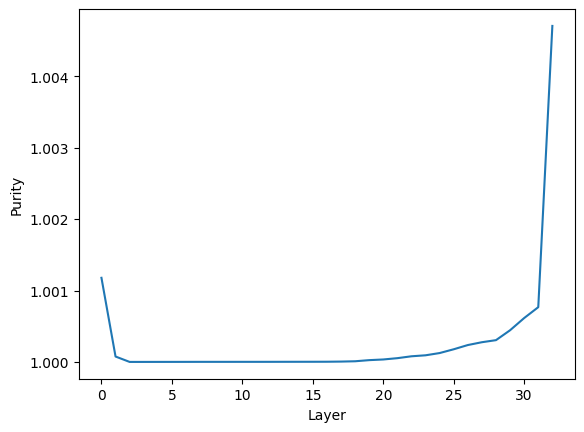

In [23]:
plt.plot(purity_by_layer)
plt.xlabel('Layer')
plt.ylabel('Purity')

## Check if it's getting the answers right

In [24]:
from transformers import AutoTokenizer, AutoModelForCausalLM

tokenizer = AutoTokenizer.from_pretrained(args['model_name'])

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [25]:
# find the argmax over the logits for each 
# problem to get the predicted class

# logits has shape [num_questions, num_tokens, vocab_size]

final_logits = logits[:, -1, :]

# take the argmax over the final dim
predicted_class = torch.argmax(final_logits, dim=1)

# decode each prediction individually
predicted_class_str = [tokenizer.decode(i) for i in predicted_class]
predicted_class_str

['15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '15',
 '16',
 '17',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '15',
 '16',
 '17',
 '18',
 '19',
 '20',
 '21',
 '22',
 '23',
 '24',
 '25',
 '15',
 '16',
 '17',
 '18',

In [26]:
str_answers = [tokenizer.decode(i) for i in answers[:, 0]]

num_correct = 0
for i in range(len(str_answers)):
    if str_answers[i] == predicted_class_str[i]:
        num_correct += 1

num_correct / len(str_answers)

1.0